In [1]:
%matplotlib inline

import random
import joblib
import shap
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn

from pymongo import MongoClient
from sklearn.model_selection import train_test_split

import explainerdashboard

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client.pums18

In [3]:
df0 = pd.DataFrame(list(db.loc.find({})))

In [4]:
df0.shape

(2351, 5)

In [5]:
states = df0.STATE.unique()
state = random.choice(states)
state

'FL'

In [6]:
pumas = pd.DataFrame(list(db.loc.find({"STATE": state})))
puma = random.choice(df0['LOCATION'])
puma

'Meriden, Wallingford & North Haven Towns'

In [7]:
df = pd.DataFrame(list(db.lab.find({'LOCATION':puma})))

In [8]:
df.shape

(620, 26)

In [9]:
sum_weights = df['WGHT'].sum()
sample_size = min(sum_weights, 500000)
sample_size

61918

In [10]:
drop_cols = ['WGHT','_id','ADJINC',]
dfs = df.sample(sample_size, weights=df['WGHT'], replace=True).drop(columns=drop_cols)

In [11]:
features = ['AGE','SCHL','INDP','OCCP','HOURS', 'COW']

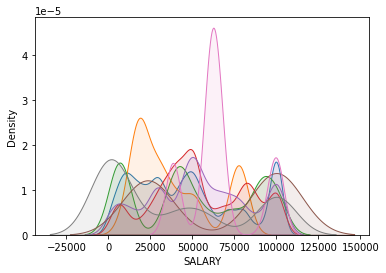

In [12]:
group_col = 'WORKERTYPE'
plot_val = 'SALARY'
fig, ax = plt.subplots()
for grp in dfs[group_col].unique():
  subset = dfs[dfs[group_col]==grp]
  ax = sns.kdeplot(subset[plot_val].clip(upper=100000),**dict(shade=True,label=grp,alpha=.1))

In [13]:
target = 'SALARY'

In [14]:
# X = dfs[features]
X = pd.get_dummies(dfs[features], drop_first=True)
y = dfs[target]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<AxesSubplot:>

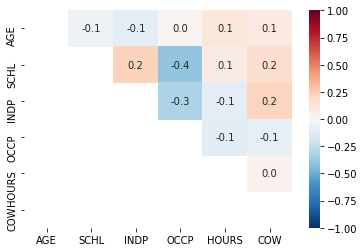

In [16]:
fig, ax = plt.subplots()
corr = dfs[features].corr()
mask = np.zeros_like(corr)  
mask[np.tril_indices_from(mask)] = True  
sns.heatmap(corr, fmt=".1f", vmin=-1, vmax=1, center=0, annot=True, ax=ax, cmap='RdBu_r', mask=mask)

In [17]:
xgr = xgb.XGBRegressor()

In [18]:
xgr.fit(X_train, y_train, eval_set=[(X_test, y_test)],)

[0]	validation_0-rmse:53395.54688
[1]	validation_0-rmse:41381.24609
[2]	validation_0-rmse:33261.58203
[3]	validation_0-rmse:28207.66211
[4]	validation_0-rmse:24287.39453
[5]	validation_0-rmse:21641.22656
[6]	validation_0-rmse:20411.06250
[7]	validation_0-rmse:18967.48242
[8]	validation_0-rmse:17130.08008
[9]	validation_0-rmse:16158.50488
[10]	validation_0-rmse:15918.12305
[11]	validation_0-rmse:15304.39941
[12]	validation_0-rmse:15128.16113
[13]	validation_0-rmse:14409.81250
[14]	validation_0-rmse:14051.99414
[15]	validation_0-rmse:12643.20801
[16]	validation_0-rmse:11877.03027
[17]	validation_0-rmse:11086.23340
[18]	validation_0-rmse:10916.57812
[19]	validation_0-rmse:10376.90039
[20]	validation_0-rmse:10055.29199
[21]	validation_0-rmse:9696.72070
[22]	validation_0-rmse:8993.96777
[23]	validation_0-rmse:8848.72754
[24]	validation_0-rmse:8426.84082
[25]	validation_0-rmse:8340.38574
[26]	validation_0-rmse:7909.33447
[27]	validation_0-rmse:7779.61328
[28]	validation_0-rmse:7551.43506
[29

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
explainer = shap.TreeExplainer(xgr)

In [20]:
dfs['PREDICTION'] = pd.Series(explainer.model.predict(X))
dfs['RESIDUAL'] = dfs[target] - dfs.PREDICTION
dfs['ERROR'] = dfs.RESIDUAL / dfs[target]

In [21]:
# pd.cut(dfs.ERROR, [-np.inf,-1,-0.5,0,0.5,1,np.inf]).value_counts(normalize=True, sort=False)

<AxesSubplot:>

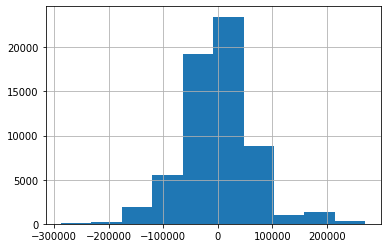

In [22]:
dfs.RESIDUAL.hist()

In [23]:
explainer = shap.explainers.Tree(xgr)

In [24]:
shap_values = explainer(X_test)

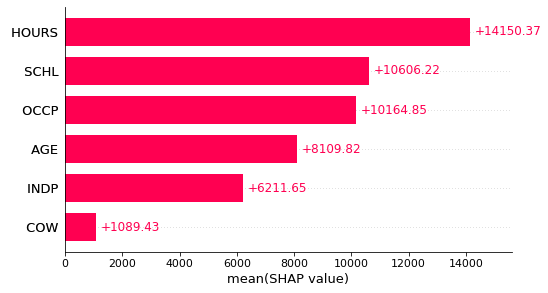

In [25]:
shap.plots.bar(shap_values) 

			Actual Wage: 70000
			Model Prediction: 68233.14


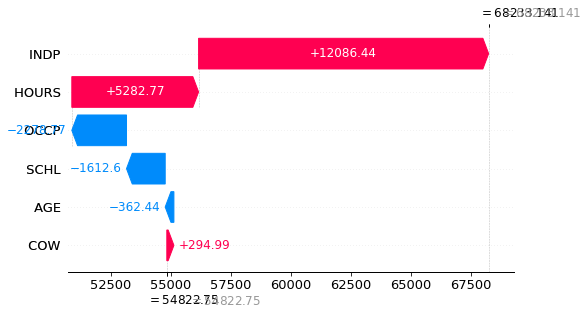

AGE        31
SCHL       20
INDP      770
OCCP     7315
HOURS      40
COW         1
Name: 499, dtype: int64

In [26]:
idx = random.choice(range(1, len(X_test)))
wage = round(y_test.iloc[idx],2)
pred = explainer.model.predict(X_test.iloc[idx]).round(2)

print(f"\t\t\tActual Wage: {wage}")
print(f"\t\t\tModel Prediction: {pred}")

plot_values = shap_values[idx, :], X_test.iloc[idx, :]
# shap.decision_plot(explainer.expected_value, shap_values[idx], features=X_test.columns)
# shap.force_plot(explainer.expected_value, shap_values[idx], features=X_test.columns)
shap.plots.waterfall(shap_values[idx])
X_test.iloc[idx]

In [27]:
# shap.plots.decision(explainer.expected_value, shap_values.values[idx], features=X_test)

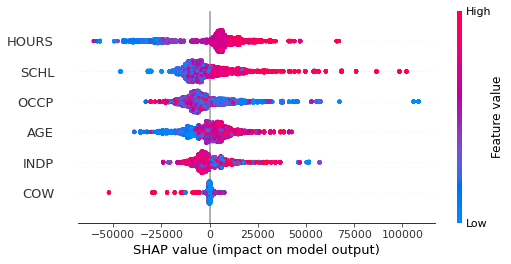

In [28]:
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_values)

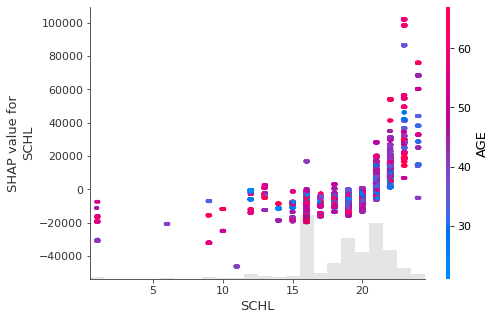

In [29]:
shap.plots.scatter(shap_values[:,"SCHL"], color=shap_values)

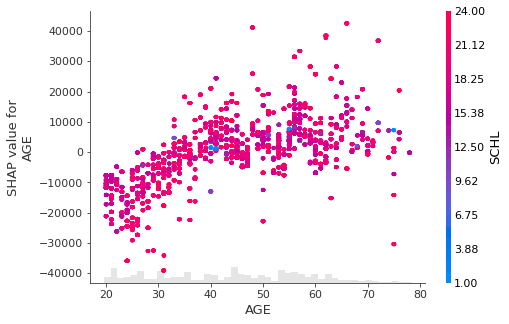

In [30]:
shap.plots.scatter(shap_values[:,"AGE"], color=shap_values)

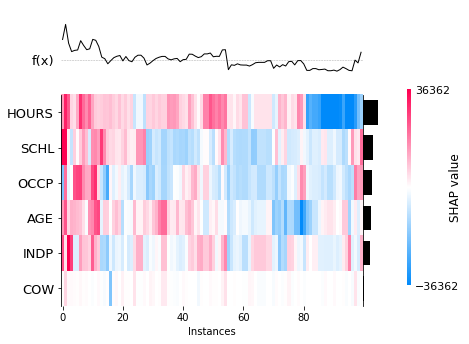

In [31]:
shap.plots.heatmap(shap_values[idx:idx+100])

In [32]:
# fit a GAM model to the data
# import interpret.glassbox
# model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
# model_ebm.fit(X_test, y_test)

In [33]:
# a simple linear model
# model = sklearn.linear_model.LinearRegression()
# model.fit(X_test, y_test)

In [34]:
# # compute the SHAP values for the linear model
# X_sample = X_test.sample(1000)
# background = shap.maskers.Independent(X_sample, max_samples=1000)
# explainer = shap.Explainer(model.predict, background)
# shap_values = explainer(X_sample)

In [35]:
# make a standard partial dependence plot
# sample_ind = 18
# fig,ax = shap.partial_dependence_plot(
#     "OCCP", model.predict, X, model_expected_value=True,
#     feature_expected_value=True, show=False, ice=False,
#     shap_values=shap_values[sample_ind:sample_ind+1,:],
#     shap_value_features=X.iloc[sample_ind:sample_ind+1,:]
# )

In [36]:
# explain the GAM model with SHAP
# explainer_ebm = shap.Explainer(model_ebm.predict, background)
# shap_values_ebm = explainer_ebm(X_sample)

In [37]:
# make a standard partial dependence plot with a single SHAP value overlaid
# fig,ax = shap.partial_dependence_plot(
#     "AGE", model_ebm.predict, X, model_expected_value=True,
#     feature_expected_value=True, show=False, ice=False,
#     shap_values=shap_values_ebm[sample_ind:sample_ind+1,:],
#     shap_value_features=X.iloc[sample_ind:sample_ind+1,:]
# )

In [38]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap.sample(shap_values, 100), features=X_test)

In [39]:
# fig, ax = plt.subplots()

# rpv = residuals.ResidualsPlot(xgr)
# rpv.fit(X_train, y_train)
# rpv.score(X_test, y_test)
# rpv.poof()
# fig.savefig('residuals_plot.png')

In [40]:
# residuals.prediction_error(xgr, X_test, y_test)

In [41]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

In [42]:
expl = RegressionExplainer(xgr, X_test, shap='tree')

Generating self.shap_explainer = shap.TreeExplainer(model)
Changing class type to XGBRegressionExplainer...


In [46]:
dash = ExplainerDashboard(expl, tabs=["shap_dependence"], mode='dash')

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab'...
Generating layout...
Calculating dependencies...
Registering callbacks...


In [47]:
ExplainerDashboard?

In [48]:
dash.run()

Starting ExplainerDashboard on http://localhost:8050
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "explainerdashboard.dashboards" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_8_2m1601034074.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET /assets/stylesheet.css?m=1602656260.103632 HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET /_dash-component-suites/dash_renderer/react@16.v1_8_2m1601034074.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET /_dash-component-suites/dash_table/bundle.v4_10_1m1599150409.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.v1_12_1m1600287003.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_1_1m1599150811.min.js HTTP/1.1" 200 -
127.0.0.1 - - [13/Oct/2020 23:46:47] "GET /_dash-component-suites/dash_renderer/p